In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium, transit, lines

pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

In [2]:
# HD 209458 b planetary parameters, measured
R_pl = 1.39  # Planetary radius in Jupiter radii
M_pl = 0.73  # Planetary mass in Jupiter masses
impact_parameter = 0.499  # Transit impact parameter

# A few assumptions about the planet's atmosphere
m_dot = 10 ** 10.27  # Total atmospheric escape rate in g / s
T_0 = 9100  # Wind temperature in K
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

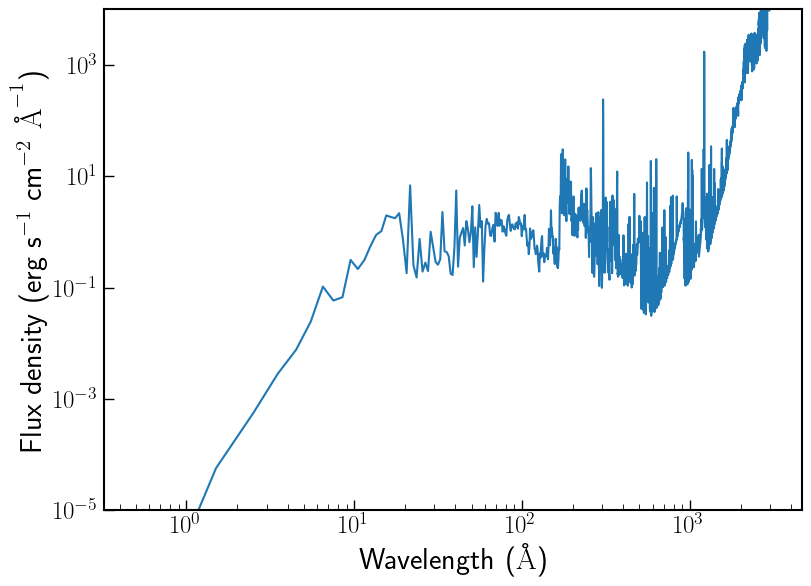

In [3]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('star_spectra/p-winds_ref_spec/solar_spectrum_scaled_lambda.dat',
                                    units)
plt.loglog(spectrum['wavelength'], spectrum['flux_lambda'])
plt.ylim(1E-5, 1E4)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()


In [4]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii

f_r, mu_bar,rates = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction,
                            m_dot, M_pl, mu_0,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True, return_rates=True)

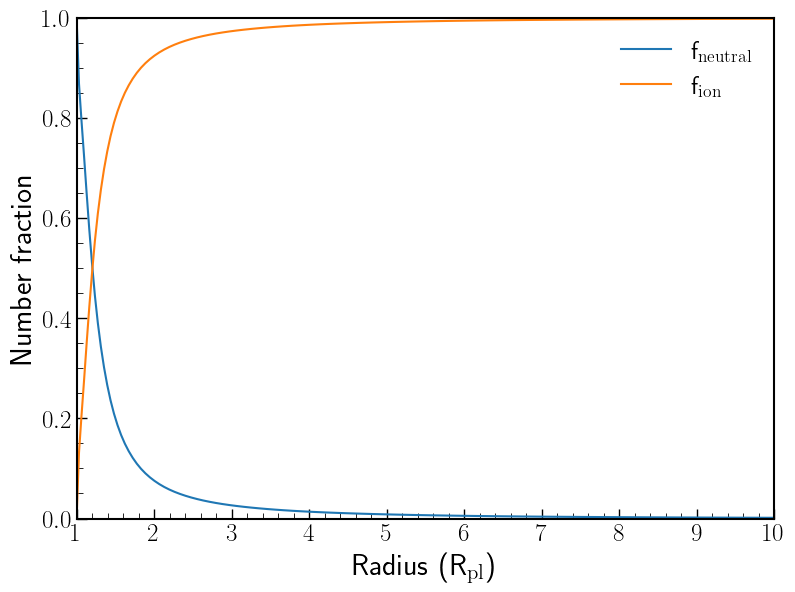

In [5]:
f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number fraction')
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

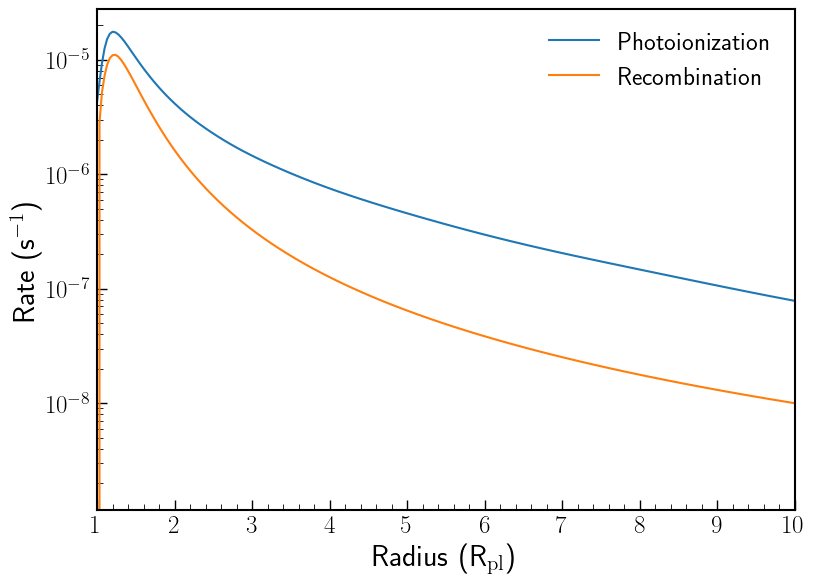

In [6]:
ionization_rate = rates['photoionization']
recombination_rate = rates['recombination']

plt.semilogy(r, ionization_rate, color='C0', label='Photoionization')
plt.semilogy(r, recombination_rate, color='C1', label='Recombination')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel(r'Rate (s$^{-1}$)')
plt.xlim(1, 10)
plt.legend()
plt.show()

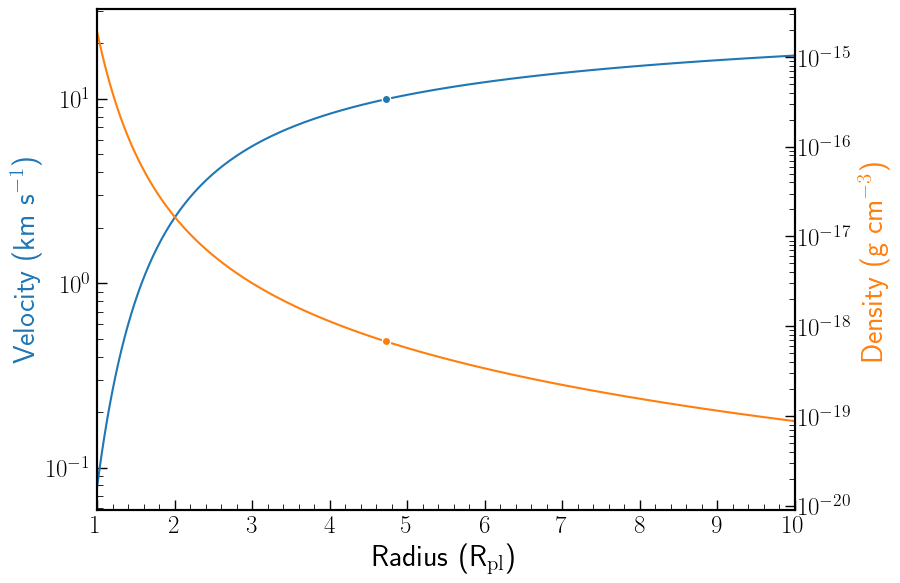

In [7]:
vs = parker.sound_speed(T_0, mu_bar)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point(M_pl, vs)  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

r_array = r * R_pl / rs
v_array, rho_array = parker.structure(r_array)

# Convenience arrays for the plots
r_plot = r_array * rs / R_pl
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 10)
plt.show()

In [8]:
# In the initial state, the fraction of singlet and triplet helium
# are, respectively, 1.0 and 0.0
initial_state = np.array([1.0, 0.0])
f_he_1, f_he_3, reaction_rates = helium.population_fraction(
    r, v_array, rho_array, f_ion,
    R_pl, T_0, h_fraction, vs, rs, rhos, spectrum,
    initial_state=initial_state, relax_solution=True, return_rates=True)

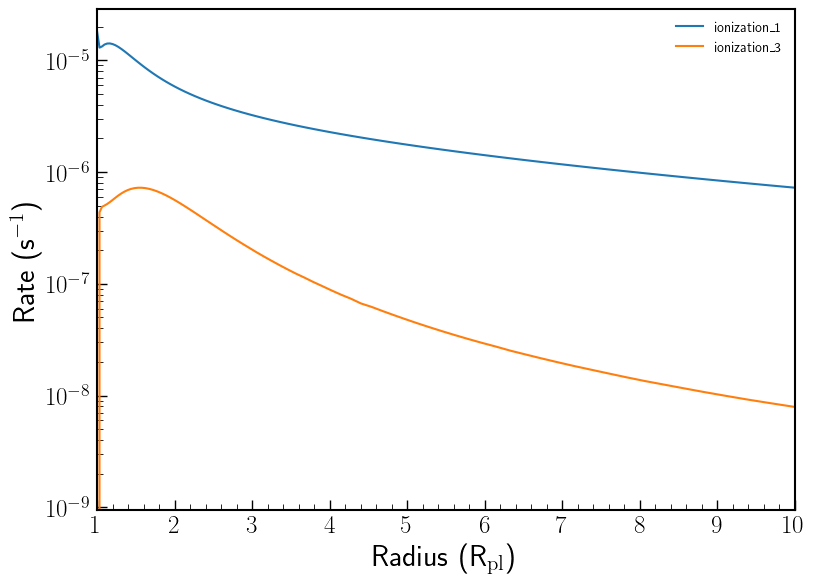

In [9]:
labels = ['ionization_1', 'ionization_3'] #reaction_rates.keys()

for l in labels:
    plt.semilogy(r, reaction_rates[l], label=l)
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel(r'Rate (s$^{-1}$)')
plt.xlim(1, 10)
plt.legend(fontsize=10)
plt.show()

In [10]:
labels

['ionization_1', 'ionization_3']

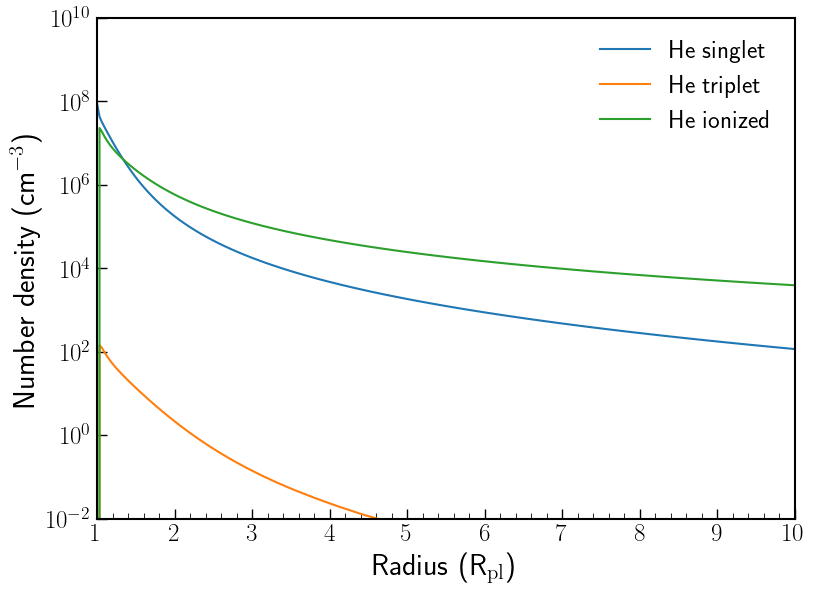

In [11]:
# Hydrogen atom mass
m_h = c.m_p.to(u.g).value

# Number density of helium nuclei
he_fraction = 1 - h_fraction
n_he = (rho_array * rhos * he_fraction / (h_fraction + 4 * he_fraction) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

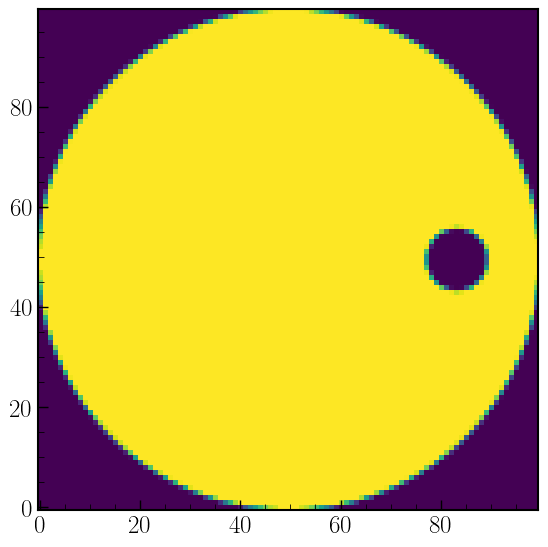

In [14]:
# First convert everything to SI units because they make our lives
# much easier.
R_pl_physical = R_pl * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
v_SI = v_array * vs * 1000  # Velocity of the outflow in m / s
n_he_3_SI = n_he_3 * 1E6  # Volumetric densities in 1 / m ** 3
planet_to_star_ratio = 0.12086

# Set up the ray tracing. We will use a coarse 100-px grid size,
# but we use supersampling to avoid hard pixel edges.
flux_map, t_depth, r_from_planet = transit.draw_transit(
    planet_to_star_ratio,
    planet_physical_radius=R_pl_physical,
    impact_parameter=0,
    phase=0.3,
    supersampling=10,
    grid_size=100)

# And now we plot it just to check how the transit looks
plt.imshow(flux_map, origin='lower')
plt.show()

In [15]:
flux_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

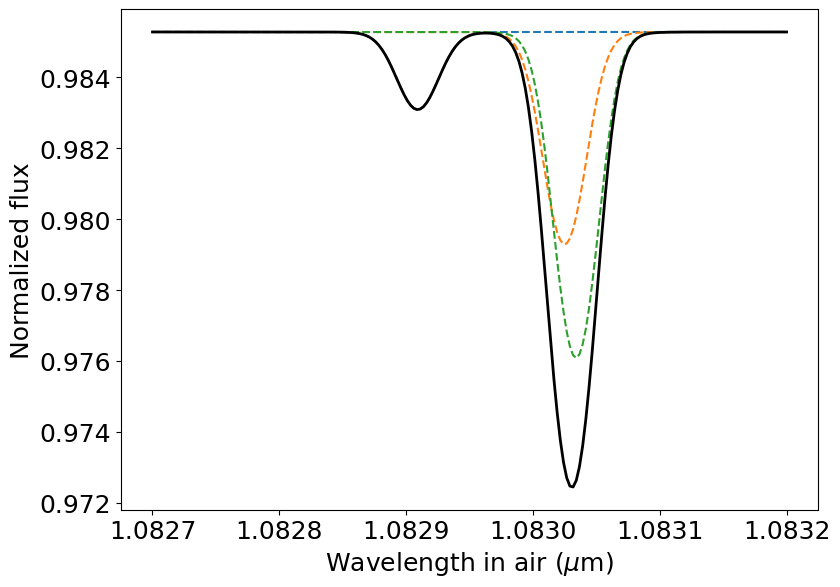

In [14]:
# Retrieve the properties of the triplet; they were hard-coded
# using the tabulated values of the NIST database
# wX = central wavelength, fX = oscillator strength, a_ij = Einstein coefficient
w0, w1, w2, f0, f1, f2, a_ij = lines.he_3_properties()

m_He = 4 * 1.67262192369e-27  # Helium atomic mass in kg
wl = np.linspace(1.0827, 1.0832, 200) * 1E-6  # Wavelengths in m

# First, let's do the radiative transfer for each line of the triplet
# separately. Check the documentation to understand what are the
# input parameters, as there are many of them.

# Another important thing to have in mind is that the formal calculation
# of the radiative transfer can take a long time. To make it faster,
# there is an option that assumes something about the atmosphere
# and accelerates the modeling. That approximation is triggered by the
# `wind_broadening_method` input parameter set to `'average'`. If you want
# to do the formal calculation, set `wind_broadening_method` to `'formal'`.
# The default is `'average'`.
method = 'formal'

spectrum_0, _ = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w0, f0, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)
spectrum_1, _ = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w1, f1, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)
spectrum_2, _ = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w2, f2, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)

# Finally let's calculate the combined spectrum of all lines in the triplet
# To do that, we combine all the line properties in their respective arrays
w_array = np.array([w0, w1, w2])
f_array = np.array([f0, f1, f2])
a_array = np.array([a_ij, a_ij, a_ij])  # This is the same for all lines in then triplet
spectrum, tau = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wl, T_0, m_He, wind_broadening_method=method)

plt.plot(wl * 1E6, spectrum_0, ls='--')
plt.plot(wl * 1E6, spectrum_1, ls='--')
plt.plot(wl * 1E6, spectrum_2, ls='--')
plt.plot(wl * 1E6, spectrum, color='k', lw=2)
plt.xlabel('Wavelength in air ($\mu$m)')
plt.ylabel('Normalized flux')
plt.show()

In [17]:
tau

array([[[2.43435279e-12, 2.47940780e-12, 2.52583300e-12, ...,
         8.55592110e-12, 8.26736996e-12, 7.99402691e-12],
        [2.50435318e-12, 2.55072611e-12, 2.59851046e-12, ...,
         8.80942377e-12, 8.51192448e-12, 8.23013453e-12],
        [2.57766046e-12, 2.62541120e-12, 2.67461638e-12, ...,
         9.07416349e-12, 8.76735295e-12, 8.47677159e-12],
        ...,
        [2.57766046e-12, 2.62541120e-12, 2.67461638e-12, ...,
         9.07416349e-12, 8.76735295e-12, 8.47677159e-12],
        [2.50435318e-12, 2.55072611e-12, 2.59851046e-12, ...,
         8.80942377e-12, 8.51192448e-12, 8.23013453e-12],
        [2.43435279e-12, 2.47940780e-12, 2.52583300e-12, ...,
         8.55592110e-12, 8.26736996e-12, 7.99402691e-12]],

       [[2.54041822e-12, 2.58746981e-12, 2.63595406e-12, ...,
         8.93992633e-12, 8.63782533e-12, 8.35169119e-12],
        [2.61887039e-12, 2.66739477e-12, 2.71739768e-12, ...,
         9.22270192e-12, 8.91068012e-12, 8.61517775e-12],
        [2.69620640e-12, 

In [19]:
np.shape(flux_map)

(100, 100)

In [45]:
optical_depth = transit.optical_depth_2d(
                                        r_SI, n_he_3_SI, v_SI, w0, f0, a_ij,
                                        wl, T_0, m_He, z_grid_size=30, wind_broadening_method=method)

In [47]:
np.shape(optical_depth)

(100, 200)

In [48]:
r_SI

array([9.93738800e+07, 1.02426885e+08, 1.05573685e+08, 1.08817163e+08,
       1.12160288e+08, 1.15606122e+08, 1.19157820e+08, 1.22818635e+08,
       1.26591919e+08, 1.30481128e+08, 1.34489822e+08, 1.38621673e+08,
       1.42880464e+08, 1.47270096e+08, 1.51794588e+08, 1.56458083e+08,
       1.61264851e+08, 1.66219296e+08, 1.71325953e+08, 1.76589498e+08,
       1.82014753e+08, 1.87606684e+08, 1.93370413e+08, 1.99311217e+08,
       2.05434537e+08, 2.11745981e+08, 2.18251327e+08, 2.24956533e+08,
       2.31867739e+08, 2.38991274e+08, 2.46333661e+08, 2.53901624e+08,
       2.61702092e+08, 2.69742211e+08, 2.78029340e+08, 2.86571071e+08,
       2.95375224e+08, 3.04449861e+08, 3.13803294e+08, 3.23444086e+08,
       3.33381067e+08, 3.43623336e+08, 3.54180271e+08, 3.65061542e+08,
       3.76277111e+08, 3.87837249e+08, 3.99752543e+08, 4.12033903e+08,
       4.24692576e+08, 4.37740154e+08, 4.51188585e+08, 4.65050184e+08,
       4.79337645e+08, 4.94064051e+08, 5.09242887e+08, 5.24888054e+08,
      